# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

* Thumbs up:  Increase the volume
* Thumbs down: Decrease the volume
* Left swipe: 'Jump' backwards 10 seconds
* Right swipe: 'Jump' forward 10 seconds  
* Stop: Pause the movie

Each video is a sequence of 30 frames (or images). 

## Data 

We can get the data from the following link.
https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL

## Outcomes or Goal for the project

You need to accomplish the following in the project:

1. **Generator :** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model :** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up :** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

#### There are certain things you should keep in mind before proceeding further:

* Use the correct container: 'Tensorflow 1.5.0 GPU Py3' when you are using a GPU machine, else it'll throw an error similar to 'the kernel died'.
* Use a C2/CPU machine to get the data on your persistent storage.
* Whenever you modify your model, run the notebook from the beginning. This is to reset the initialisations and the generator.
* To check the GPU usage, execute 'nvidia-smi' on the terminal.

In [1]:
## Importing the required libraries

import numpy as np
import os
import pathlib
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import time

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
## Importing some other libraries

from PIL import Image, ImageFilter, ImageEnhance
import warnings
import cv2
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
## Importing Model building and related libraries

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, LSTM, GRU, TimeDistributed, Bidirectional
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.recurrent import LSTM
from keras import optimizers
import abc

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [6]:
batch_size = 50

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
## Let us define a class for the generator and some other required functions

class ModelBuilder(metaclass = abc.ABCMeta) :

  ## Defining the Training and Validation Project data paths
  def initialize_path(self, project_folder) :
    self.train_csv = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
    self.val_csv = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
    self.train_data = project_folder + '/' + 'train'
    self.val_data = project_folder + '/' + 'val'
    self.num_train_sequences = len(self.train_csv)
    self.num_val_sequences = len(self.val_csv)

  ## Method to initializing Image properties
  def initialize_properties(self, img_height=100, img_width=100) :
    self.img_height = img_height
    self.img_width = img_width
    self.num_of_classes = 5
    self.total_frames = 30
    self.channels = 3

  ## Method to initialize the Hyperparameters
  def initialize_hyperparameters(self, batch_size = 30, epochs = 30, frames_to_sample = 30) :
    self.frames_to_sample = frames_to_sample
    self.batch_size = batch_size
    self.epochs = epochs

  ## Method for training a model and returning history after fit.generator. 
  def training_model(self, model, augment_data = False) :
    
    ## Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = self.generator(self.train_data, self.train_csv, batch_size, augmentation = augment_data)
    val_generator = self.generator(self.val_data, self.val_csv, batch_size)

    ## Below code helps in saving our models
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    # Write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    ## The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make
    if (self.num_train_sequences % self.batch_size) == 0:
       steps_per_epoch = int(self.num_train_sequences / self.batch_size)
    else:
        steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

    if (self.num_val_sequences % self.batch_size) == 0:
        validation_steps = int(self.num_val_sequences / self.batch_size)
    else:
        validation_steps = (self.num_val_sequences // self.batch_size) + 1

    ## Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model
    ## at the end of each epoch.
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    return history

  def generator(self,source_path, folder_list, batch_size=15, augmentation=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augmentation)
                yield batch_data, batch_labels 

            remaining_seq=len(t) % batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augmentation,remaining_seq)
                yield batch_data, batch_labels 
    
    
  def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augmentation,remaining_seq=0):
  
      seq_len = remaining_seq if remaining_seq else batch_size
  
      batch_data = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels)) 
      batch_labels = np.zeros((seq_len,self.num_of_classes)) 
  
      if (augmentation): 
        batch_data_aug = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels))

      
      for folder in range(seq_len): 
          imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
          for idx,item in enumerate(img_idx):
              #performing image reading and resizing
              image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
              image_resized=imresize(image,(self.img_height,self.img_width,3))
          
              #normalizing the images
              batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
              batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
              batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
          
              if (augmentation):
                  shifted = cv2.warpAffine(image, 
                                            np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                          (image.shape[1], image.shape[0]))
                  
                  gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                  x0, y0 = np.argwhere(gray > 0).min(axis=0)
                  x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  # cropping the images to have the targeted gestures and remove the noise from the images.
                  cropped=shifted[x0:x1,y0:y1,:]
                  
                  image_resized=imresize(cropped,(self.img_height,self.img_width,3))
                  
                  #shifted = cv2.warpAffine(image_resized, 
                  #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                  #                        (image_resized.shape[1], image_resized.shape[0]))
          
                  batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                  batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                  batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
              
          
          batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          
  
      if (augmentation):
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])

      
      return(batch_data,batch_labels)
  
  @abc.abstractmethod
  def init_Model(self) :
    pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'

curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 3 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 3


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Let us first begin with some parameter tuning experiments by creating a sample Model and executing with different parameters

In [24]:
class Conv3D_Model(ModelBuilder) :
  def init_Model(self, kernelSize=(3,3,3)) :

    model = Sequential()
    #First Convulation layer
    model.add(Conv3D(32, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                     activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 30% Fraction of the input units to drop.
    model.add(Dropout(0.3))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])

    return model

In [8]:
project_folder = '/home/datasets/Project_data'

In [ ]:
## Creating an object for the Model Builder class
conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj_model.summary()

2023-05-28 07:11:01.622948: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-28 07:11:01.623013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-28 07:11:01.623059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    27680     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 80, 80, 32)   128       
 hNormalization)                                                 
                                                        

In [ ]:
## Let us test the generator function as well

test_generator_obj = Conv3D_Model()
test_generator_obj.initialize_path(project_folder)
test_generator_obj.initialize_properties(img_height=160, img_width=160)
test_generator_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=15, epochs=3)

generator = test_generator_obj.generator(test_generator_obj.val_data, test_generator_obj.val_csv, augmentation=True, batch_size=15)
batch_data, batch_labels = next(generator)

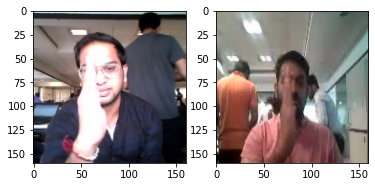

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,10,:,:,:])   
axes[1].imshow(batch_data[6,17,:,:,:])

#### Let us experiment to get various parameters and check that certain optimized parameter values

In [ ]:
## We will try to get the limit on memory sources

## Creating an object for the Model Builder class
conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size = 40, epochs= 2)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

Epoch 1/3


ResourceExhaustedError: ignored

We will experiment with differnt batch sizes, sample frames and image resolutions to get the trade of between them and the time taken for each model

In [ ]:
## Experimenting with batch size = 15, image size = 100 X 100, sample frames = 20

import time
start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=100, img_width=100)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/3
45/45 [==============================] - ETA: 0s - loss: 1.8191 - categorical_accuracy: 0.3680
Epoch 00001: saving model to model_init_2023-05-2813_38_16.812671/model-00001-1.81913-0.36802-1.60271-0.21000.h5
45/45 [==============================] - 108s 2s/step - loss: 1.8191 - categorical_accuracy: 0.3680 - val_loss: 1.6027 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/3
45/45 [==============================] - ETA: 0s - loss: 1.4955 - categorical_accuracy: 0.4615
Epoch 00002: saving model to model_init_2023-05-2813_38_16.812671/model-00002-1.49546-0.46154-3.00571-0.17000.h5
45/45 [==============================] - 106s 2s/step - loss: 1.4955 - categorical_accuracy: 0.4615 - val_loss: 3.0057 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
45/45 [==============================] - ETA: 0s - loss: 1.2394 - categorical_accuracy: 0.4962
Epoch 00003: saving model to model_init_2023-05-2813_38_16.812671/model-00003-1.23939-0.49623-3.23694-0.23000.h5
45/45 [=====

In [ ]:
## Experimenting with batch size = 15, image size = 160 X 160, sample frames = 20
import time
start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=15, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

2023-05-28 13:38:36.788368: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-28 13:38:36.788427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Epoch 1/3


2023-05-28 13:38:41.458537: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.7361 - categorical_accuracy: 0.3529
Epoch 00001: saving model to model_init_2023-05-2813_38_16.812671/model-00001-1.73615-0.35294-2.70842-0.22000.h5
45/45 [==============================] - 124s 3s/step - loss: 1.7361 - categorical_accuracy: 0.3529 - val_loss: 2.7084 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/3
45/45 [==============================] - ETA: 0s - loss: 1.3358 - categorical_accuracy: 0.4902
Epoch 00002: saving model to model_init_2023-05-2813_38_16.812671/model-00002-1.33581-0.49020-3.75887-0.16000.h5
45/45 [==============================] - 121s 3s/step - loss: 1.3358 - categorical_accuracy: 0.4902 - val_loss: 3.7589 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/3
45/45 [==============================] - ETA: 0s - loss: 1.1963 - categorical_accuracy: 0.5551
Epoch 00003: saving model to model_init_2023-05-2813_38_16.812671/model-00003-1.19629-0.55505-3.07240-0.11000.h5
45/45 [===============

In [ ]:
## Experimenting with batch size = 20, image size = 160 X 160, sample frames = 20

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=20, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

2023-05-28 17:10:19.807868: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-28 17:10:19.807942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Epoch 1/3


2023-05-28 17:10:27.538886: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.7885 - categorical_accuracy: 0.3741
Epoch 00001: saving model to model_init_2023-05-2817_09_52.050892/model-00001-1.78851-0.37406-2.18651-0.27000.h5
34/34 [==============================] - 142s 4s/step - loss: 1.7885 - categorical_accuracy: 0.3741 - val_loss: 2.1865 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.3397 - categorical_accuracy: 0.4781
Epoch 00002: saving model to model_init_2023-05-2817_09_52.050892/model-00002-1.33971-0.47813-2.43784-0.30000.h5
34/34 [==============================] - 118s 4s/step - loss: 1.3397 - categorical_accuracy: 0.4781 - val_loss: 2.4378 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.1164 - categorical_accuracy: 0.5777
Epoch 00003: saving model to model_init_2023-05-2817_09_52.050892/model-00003-1.11639-0.57768-4.81199-0.13000.h5
34/34 [===============

In [ ]:
## Experimenting with batch size = 20, image size = 160 X 160, sample frames = 30 

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=20, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.5525 - categorical_accuracy: 0.4268
Epoch 00001: saving model to model_init_2023-05-2817_17_18.506936/model-00001-1.55247-0.42685-1.87936-0.17000.h5
34/34 [==============================] - 181s 5s/step - loss: 1.5525 - categorical_accuracy: 0.4268 - val_loss: 1.8794 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.1610 - categorical_accuracy: 0.5732
Epoch 00002: saving model to model_init_2023-05-2817_17_18.506936/model-00002-1.16101-0.57315-3.85353-0.33000.h5
34/34 [==============================] - 176s 5s/step - loss: 1.1610 - categorical_accuracy: 0.5732 - val_loss: 3.8535 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 1.0784 - categorical_accuracy: 0.5852
Epoch 00003: saving model to model_init_2023-05-2817_17_18.506936/model-00003-1.07837-0.58522-2.89109-0.33000.h5
34/34 [=====

In [ ]:
## Experimenting with batch size = 30, image size = 160 X 160, sample frames = 30

start = time.time()

conv_obj = Conv3D_Model()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=30, batch_size=30, epochs=3)
conv_obj_model = conv_obj.init_Model()
conv_obj.training_model(conv_obj_model)

end = time.time()

print("Total Params:", conv_obj_model.count_params())
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.6050 - categorical_accuracy: 0.4087
Epoch 00001: saving model to model_init_2023-05-2817_17_18.506936/model-00001-1.60499-0.40875-1.62513-0.23000.h5
23/23 [==============================] - 174s 8s/step - loss: 1.6050 - categorical_accuracy: 0.4087 - val_loss: 1.6251 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.1664 - categorical_accuracy: 0.5747
Epoch 00002: saving model to model_init_2023-05-2817_17_18.506936/model-00002-1.16637-0.57466-4.17211-0.21000.h5
23/23 [==============================] - 174s 8s/step - loss: 1.1664 - categorical_accuracy: 0.5747 - val_loss: 4.1721 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 1.0898 - categorical_accuracy: 0.5656
Epoch 00003: saving model to model_init_2023-05-2817_17_18.506936/model-00003-1.08980-0.56561-3.18687-0.16000.h5
23/23 [=====

### Experiment Summary

* Experiment 1 (Batch size = 15, image size = 100 X 100, sample frames = 20) -> 321.84  secs
* Experiment 2 (Batch size = 15, image size = 160 X 160, sample frames = 20) -> 369.22  secs
* Experiment 3 (Batch size = 20, image size = 160 X 160, sample frames = 20) -> 383.27  secs
* Experiment 4 (Batch size = 20, image size = 160 X 160, sample frames = 30) -> 534.01  secs
* Experiment 5 (Batch size = 30, image size = 160 X 160, sample frames = 30) -> 526.42  secs

We experimented with batch sizes from 15 to 30 and image resolution 100 X 100 and 160 X 160.
From above summary, we can clearly observe that the increase in sample frames and image sizes results in more time increase than increasing the batch sizes.



### Model 1

Batch Size = 35 and No of Epochs = 16

In [ ]:
class Conv3D_Model1(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.3, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(32, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 30% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model                  

In [ ]:
conv_obj = Conv3D_Model1()
conv_obj.initialize_path(project_folder)
conv_obj.initialize_properties(img_height=160, img_width=160)
conv_obj.initialize_hyperparameters(frames_to_sample=20, batch_size=35, epochs=16)
conv_obj_model = conv_obj.init_Model()
conv_obj_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 32)  2624      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 10, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    27680     
                                                                 
 batch_normalization_31 (Bat  (None, 10, 80, 80, 32)   128       
 chNormalization)                                                
                                                      

In [ ]:
model_1_History = conv_obj.training_model(conv_obj_model)

Epoch 1/16
19/19 [==============================] - ETA: 0s - loss: 1.5385 - categorical_accuracy: 0.4434
Epoch 00001: saving model to model_init_2023-05-2817_44_38.543834/model-00001-1.53847-0.44344-1.51016-0.29000.h5
19/19 [==============================] - 122s 7s/step - loss: 1.5385 - categorical_accuracy: 0.4434 - val_loss: 1.5102 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/16
19/19 [==============================] - ETA: 0s - loss: 0.9618 - categorical_accuracy: 0.6380
Epoch 00002: saving model to model_init_2023-05-2817_44_38.543834/model-00002-0.96182-0.63801-2.80236-0.14000.h5
19/19 [==============================] - 119s 7s/step - loss: 0.9618 - categorical_accuracy: 0.6380 - val_loss: 2.8024 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/16
19/19 [==============================] - ETA: 0s - loss: 0.6471 - categorical_accuracy: 0.7602
Epoch 00003: saving model to model_init_2023-05-2817_44_38.543834/model-00003-0.64707-0.76018-4.39642-0.17000.h5
19/19 [==

In [10]:
## User defined method to plot the Accuracy and Validation Plots

def plot_accuracyAndLoss(history) :
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    plt.title('Training and Accuracy and Loss')
    plt.grid(color = 'teal', linestyle = '--', linewidth = 0.5)
    plt.show()   

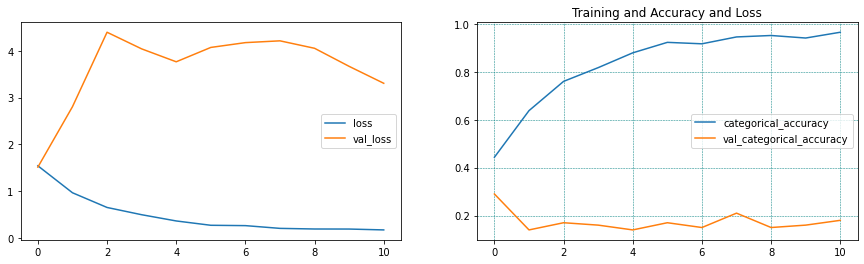

In [ ]:
plot_accuracyAndLoss(model_1_History)

### Model 1 - Observations

We can observe that the model above is underfitting

### Model 2

Reducing the Image resolution to 120 X 120, batch to 25, kernel size = (2,2,2) and increasing epochs to 20.

In [ ]:
conv_obj_2 = Conv3D_Model1()
conv_obj_2.initialize_path(project_folder)
conv_obj_2.initialize_properties(img_height=120, img_width=120)
conv_obj_2.initialize_hyperparameters(frames_to_sample=20, batch_size=25, epochs=20)
conv_obj_model_2 = conv_obj_2.init_Model(kernelSize = (2, 2, 2), dropout=0.5, dense_Neurons=128)
conv_obj_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 120, 120, 32)  800       
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 60, 60, 32)    8224      
                                                                 
 batch_normalization_37 (Bat  (None, 10, 60, 60, 32)   128       
 chNormalization)                                                
                                                      

In [ ]:
model_2_History = conv_obj_2.training_model(conv_obj_model_2)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 2.0325 - categorical_accuracy: 0.3152
Epoch 00001: saving model to model_init_2023-05-2817_44_38.543834/model-00001-2.03248-0.31523-2.67661-0.21000.h5
27/27 [==============================] - 107s 4s/step - loss: 2.0325 - categorical_accuracy: 0.3152 - val_loss: 2.6766 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.4426 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2023-05-2817_44_38.543834/model-00002-1.44256-0.50528-5.23074-0.21000.h5
27/27 [==============================] - 106s 4s/step - loss: 1.4426 - categorical_accuracy: 0.5053 - val_loss: 5.2307 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.1616 - categorical_accuracy: 0.5958
Epoch 00003: saving model to model_init_2023-05-2817_44_38.543834/model-00003-1.16162-0.59578-7.53282-0.16000.h5
27/27 [==

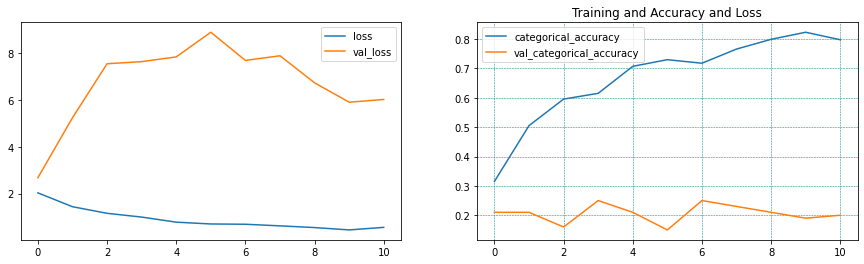

In [ ]:
plot_accuracyAndLoss(model_2_History)

### Model 2 - Observations

We can clearly see, performance has not been increased

### Model 3

Inreasing the dropout from 0.3 to 0.5 and epochs = 20 reducing the batch size from 35 to 20. We will augment the data for this model

In [ ]:
conv_obj_3 = Conv3D_Model1()
conv_obj_3.initialize_path(project_folder)
conv_obj_3.initialize_properties(img_height=160, img_width=160)
conv_obj_3.initialize_hyperparameters(frames_to_sample=20, batch_size=20, epochs=20)
conv_obj_model_3 = conv_obj_3.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_3.summary()

2023-05-28 19:16:02.987611: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-28 19:16:02.987689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    27680     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 80, 80, 32)   128       
 hNormalization)                                                 
                                                        

In [ ]:
model_3_History = conv_obj_3.training_model(conv_obj_model_3, augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3550 - categorical_accuracy: 0.5000
Epoch 00001: saving model to model_init_2023-05-2819_14_04.106807/model-00001-1.35503-0.50000-2.59840-0.32000.h5
34/34 [==============================] - 212s 6s/step - loss: 1.3550 - categorical_accuracy: 0.5000 - val_loss: 2.5984 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1664 - categorical_accuracy: 0.5724
Epoch 00002: saving model to model_init_2023-05-2819_14_04.106807/model-00002-1.16636-0.57240-2.81094-0.33000.h5
34/34 [==============================] - 210s 6s/step - loss: 1.1664 - categorical_accuracy: 0.5724 - val_loss: 2.8109 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9599 - categorical_accuracy: 0.6425
Epoch 00003: saving model to model_init_2023-05-2819_14_04.106807/model-00003-0.95990-0.64253-3.74082-0.28000.h5
34/34 [==

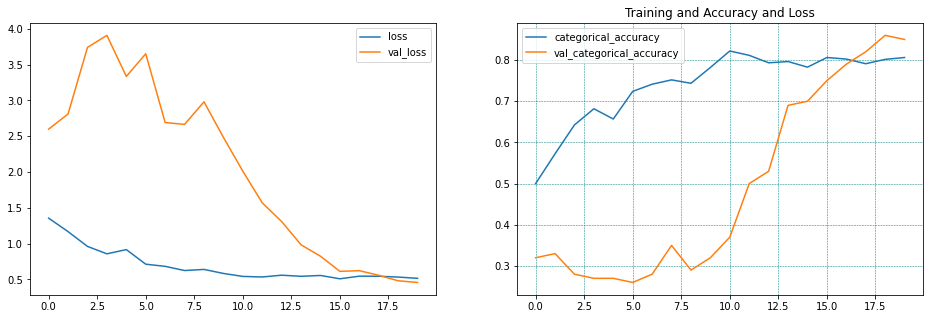

In [ ]:
plot_accuracyAndLoss(model_3_History)

### Model 3 - Observations

The above model seems to understand the trends better than the prior models. Let us define our model again for better results

### Model 4

Adding more layers to the above models

In [17]:
class Conv3D_Model4(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.25, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(Conv3D(32, kernelSize, activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [18]:
conv_obj_4 = Conv3D_Model4()
conv_obj_4.initialize_path(project_folder)
conv_obj_4.initialize_properties(img_height=160, img_width=160)
conv_obj_4.initialize_hyperparameters(frames_to_sample=20, batch_size=20, epochs=25)
conv_obj_model_4 = conv_obj_4.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 conv3d_14 (Conv3D)          (None, 20, 160, 160, 32)  13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 10, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 conv3d_15 (Conv3D)          (None, 10, 80, 80, 32)    27680     
                                                                 
 conv3d_16 (Conv3D)          (None, 10, 80, 80, 64)   

In [20]:
history_model4 = conv_obj_4.training_model(conv_obj_model_4,augment_data=True)

Epoch 1/25


2023-05-29 18:27:33.707106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 2.2509 - categorical_accuracy: 0.2858
Epoch 00001: saving model to model_init_2023-05-2918_22_09.933637/model-00001-2.25087-0.28582-30.85339-0.23000.h5
34/34 [==============================] - 233s 7s/step - loss: 2.2509 - categorical_accuracy: 0.2858 - val_loss: 30.8534 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.9225 - categorical_accuracy: 0.3311
Epoch 00002: saving model to model_init_2023-05-2918_22_09.933637/model-00002-1.92252-0.33107-9.25132-0.26000.h5
34/34 [==============================] - 212s 6s/step - loss: 1.9225 - categorical_accuracy: 0.3311 - val_loss: 9.2513 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.7457 - categorical_accuracy: 0.3560
Epoch 00003: saving model to model_init_2023-05-2918_22_09.933637/model-00003-1.74567-0.35596-1.60506-0.39000.h5
34/34 [===========

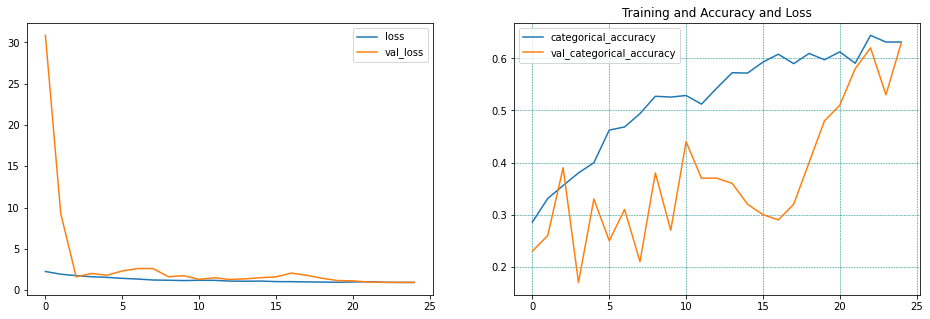

In [23]:
plot_accuracyAndLoss(history_model4)

### Model 4 - Observations

Adding the layers was not much help with respect to the model performance. Let us try reducing and check the performance

### Model 5

Reducing the parameters

In [38]:
class Conv3D_Model5(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.25, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(32, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(self.num_of_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    return model

In [39]:
conv_obj_5 = Conv3D_Model5()
conv_obj_5.initialize_path(project_folder)
conv_obj_5.initialize_properties(img_height=120, img_width=120)
conv_obj_5.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=20)
conv_obj_model_5 = conv_obj_5.init_Model(dropout=0.3, dense_Neurons=128)
conv_obj_model_5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 18, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 60, 60, 32)    0         
 g3D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 9, 60, 60, 32)    128       
 chNormalization)                                                
                                                                 
 conv3d_31 (Conv3D)          (None, 9, 60, 60, 32)     27680     
                                                                 
 batch_normalization_36 (Bat  (None, 9, 60, 60, 32)    128       
 chNormalization)                                                
                                                      

In [40]:
history_model5 = conv_obj_5.training_model(conv_obj_model_5,augment_data=True)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4840 - categorical_accuracy: 0.3643
Epoch 00001: saving model to model_init_2023-05-3005_51_55.659566/model-00001-1.48396-0.36425-1.70716-0.18000.h5
34/34 [==============================] - 173s 5s/step - loss: 1.4840 - categorical_accuracy: 0.3643 - val_loss: 1.7072 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3911 - categorical_accuracy: 0.4223
Epoch 00002: saving model to model_init_2023-05-3005_51_55.659566/model-00002-1.39108-0.42232-1.59679-0.22000.h5
34/34 [==============================] - 169s 5s/step - loss: 1.3911 - categorical_accuracy: 0.4223 - val_loss: 1.5968 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.4563
Epoch 00003: saving model to model_init_2023-05-3005_51_55.659566/model-00003-1.35430-0.45626-1.47803-0.34000.h5
34/34 [==

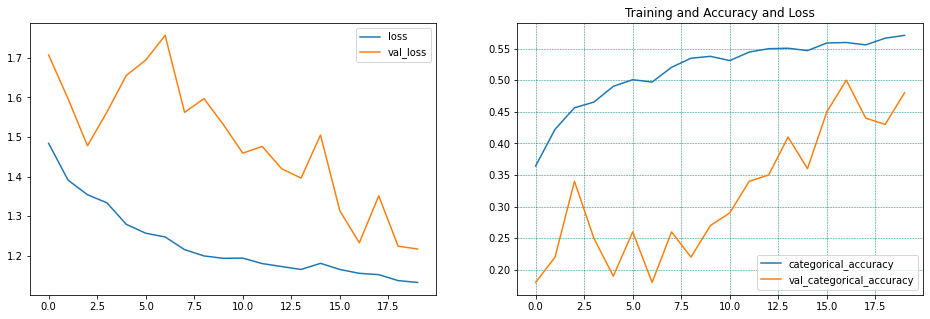

In [41]:
plot_accuracyAndLoss(history_model5)

### Model 5 - Observations

The above model gave around 50% as best validation accuracy

### Model 6

Reducing the number of parameters again

In [54]:
class Conv3D_Model6(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.25, dense_Neurons = 64) :

        model = Sequential()
        model.add(Conv3D(16, kernelSize,  activation='relu', padding='same',
                 input_shape=(self.frames_to_sample,self.img_height,self.img_width,self.channels)))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2),  activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2),  activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_Neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_Neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_of_classes,activation='softmax')) 
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
        return model

In [55]:
conv_obj_6 = Conv3D_Model6()
conv_obj_6.initialize_path(project_folder)
conv_obj_6.initialize_properties(img_height=120, img_width=120)
conv_obj_6.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=25)
conv_obj_model_6 = conv_obj_6.init_Model(dropout=0.3, dense_Neurons=64)
conv_obj_model_6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 batch_normalization_53 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_43 (Conv3D)          (None, 9, 60, 60, 32)     13856     
                                                                 
 batch_normalization_54 (Bat  (None, 9, 60, 60, 32)    128       
 chNormalization)                                                
                                                     

In [ ]:
history_model6 = conv_obj_6.training_model(conv_obj_model_6,augment_data=True)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6488 - categorical_accuracy: 0.3952
Epoch 00001: saving model to model_init_2023-05-3005_51_55.659566/model-00001-1.64883-0.39517-1.84886-0.21000.h5
34/34 [==============================] - 171s 5s/step - loss: 1.6488 - categorical_accuracy: 0.3952 - val_loss: 1.8489 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2911 - categorical_accuracy: 0.5332
Epoch 00002: saving model to model_init_2023-05-3005_51_55.659566/model-00002-1.29108-0.53318-2.44567-0.14000.h5
34/34 [==============================] - 171s 5s/step - loss: 1.2911 - categorical_accuracy: 0.5332 - val_loss: 2.4457 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9997 - categorical_accuracy: 0.6063
Epoch 00003: saving model to model_init_2023-05-3005_51_55.659566/model-00003-0.99969-0.60633-2.77916-0.23000.h5
3

In [ ]:
plot_accuracyAndLoss(history_model6)

### Model 6 - Observations

### Model 7

#### Let us now build CNN - LSTM Model

In [11]:
class Conv2D_LSTM(ModelBuilder) :
  def init_Model(self, kernelSize = (3, 3), dropout = 0.25, dense_Neurons = 64, LSTM_neurons = 64) :

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(BatchNormalization()))

    #Second Convulation Layer
    model.add(TimeDistributed(Conv2D(32, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    #Third Convulation Layer
    model.add(TimeDistributed(Conv2D(32, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    #Fourth Convulation Layer
    model.add(TimeDistributed(Conv2D(64, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(TimeDistributed(Conv2D(128, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(TimeDistributed(Flatten()))

    LSTM(LSTM_neurons)

    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam()
    model.compile(optimiser, loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [13]:
conv_obj_7 = Conv2D_LSTM()
conv_obj_7.initialize_path(project_folder)
conv_obj_7.initialize_properties(img_height=120, img_width=120)
conv_obj_7.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=20)
conv_obj_model_7 = conv_obj_7.init_Model(dropout=0.25, dense_Neurons=128, LSTM_neurons=128)
conv_obj_model_7.build()
conv_obj_model_7.summary()

ValueError: You must provide an `input_shape` argument.

In [ ]:
history_model7 = conv_obj_7.training_model(conv_obj_model_7,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model7)

### Model 7 - Observations

### Model 8

We will add Augmentation in our generator function with rotation

In [9]:
class ModelBuilder_Augmentation(metaclass = abc.ABCMeta) :

  ## Defining the Training and Validation Project data paths
  def initialize_path(self, project_folder) :
    self.train_csv = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
    self.val_csv = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
    self.train_data = project_folder + '/' + 'train'
    self.val_data = project_folder + '/' + 'val'
    self.num_train_sequences = len(self.train_csv)
    self.num_val_sequences = len(self.val_csv)

  ## Method to initializing Image properties
  def initialize_properties(self, img_height=100, img_width=100) :
    self.img_height = img_height
    self.img_width = img_width
    self.num_of_classes = 5
    self.total_frames = 30
    self.channels = 3

  ## Method to initialize the Hyperparameters
  def initialize_hyperparameters(self, batch_size = 30, epochs = 30, frames_to_sample = 30) :
    self.frames_to_sample = frames_to_sample
    self.batch_size = batch_size
    self.epochs = epochs

   ## Method for training a model and returning history after fit.generator. 
  def training_model(self, model) :
    
    ## Let us create the train_generator and the val_generator which will be used in .fit_generator.
    train_generator = self.generator(self.train_data, self.train_csv, batch_size, augmentation = True)
    val_generator = self.generator(self.val_data, self.val_csv, batch_size)

    ## Below code helps in saving our models
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    # Write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
    callbacks_list = [checkpoint, LR, earlystop]

    ## The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make
    if (self.num_train_sequences % self.batch_size) == 0:
       steps_per_epoch = int(self.num_train_sequences / self.batch_size)
    else:
        steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

    if (self.num_val_sequences % self.batch_size) == 0:
        validation_steps = int(self.num_val_sequences / self.batch_size)
    else:
        validation_steps = (self.num_val_sequences // self.batch_size) + 1

    ## Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model
    ## at the end of each epoch.
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    return history

  def generator(self, source_path, folder_list, batch_size, augmentation=False):
    img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        for batch in range(num_batches):
            batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augmentation)
            yield batch_data, batch_labels

        remaining_seq = len(t) % batch_size

        if remaining_seq != 0:
            batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx,
                                                          augmentation, remaining_seq)
            yield batch_data, batch_labels

    
  def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augmentation,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_of_classes)) 
    
        if (augmentation): 
            batch_data_aug = np.zeros((seq_len,len(img_idx),self.img_height,self.img_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.img_height,self.img_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augmentation):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.img_height,self.img_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.img_width//2,self.img_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.img_width, self.img_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1            
    
        if (augmentation):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
  
  @abc.abstractmethod
  def init_Model(self) :
    pass

#### Model with Data Augmentation

In [14]:
class Conv3D_Model8(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.3, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(lr=0.0015)
    model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [15]:
conv_obj_8 = Conv3D_Model8()
conv_obj_8.initialize_path(project_folder)
conv_obj_8.initialize_properties(img_height=160, img_width=160)
conv_obj_8.initialize_hyperparameters(frames_to_sample=16, batch_size=20, epochs=20)
conv_obj_model_8 = conv_obj_8.init_Model(dropout=0.3, dense_Neurons=128)
conv_obj_model_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 160, 160, 16)  1312      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 80, 80, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 8, 80, 80, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 80, 80, 32)     13856     
                                                                 
 batch_normalization_7 (Batc  (None, 8, 80, 80, 32)    128       
 hNormalization)                                                 
                                                      

In [ ]:
history_model8 = conv_obj_8.training_model(conv_obj_model_8)

Epoch 1/20


2023-05-30 13:57:27.200088: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


 3/34 [=>............................] - ETA: 5:21 - loss: 2.2155 - categorical_accuracy: 0.3033

In [ ]:
plot_accuracyAndLoss(history_model8)

### Model 8 - Observations

### Model 9

Reducing the filter and Image resolution with Augmentation

In [ ]:
class Conv3D_Model9(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize = (2, 2, 2), dropout = 0.3, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(lr=0.0002)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [ ]:
conv_obj_9 = Conv3D_Model9()
conv_obj_9.initialize_path(project_folder)
conv_obj_9.initialize_properties(img_height=120, img_width=120)
conv_obj_9.initialize_hyperparameters(frames_to_sample=16, batch_size=20, epochs=25)
conv_obj_model_9 = conv_obj_9.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_9.summary()

In [ ]:
history_model9 = conv_obj_9.training_model(conv_obj_model_9,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model9)

### Model 9 - Observations 

### Model 10

Adding more layers to the above Augmented model

In [ ]:
class Conv3D_Model10(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.25, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(Conv3D(32, kernelSize, activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())

    #Third Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(64, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(128, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(lr=0.0015)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [ ]:
conv_obj_10 = Conv3D_Model10()
conv_obj_10.initialize_path(project_folder)
conv_obj_10.initialize_properties(img_height=120, img_width=120)
conv_obj_10.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=25)
conv_obj_model_10 = conv_obj_10.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_10.summary()

In [ ]:
history_model10 = conv_obj_10.training_model(conv_obj_model_10,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model10)

### Model 10 - Observations

### Model 11

Reducing the parameters

In [ ]:
class Conv3D_Model11(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize, dropout = 0.25, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(64, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(Conv3D(128, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = optimizers.Adam(lr=0.0003)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [ ]:
conv_obj_11 = Conv3D_Model11()
conv_obj_11.initialize_path(project_folder)
conv_obj_11.initialize_properties(img_height=120, img_width=120)
conv_obj_11.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=25)
conv_obj_model_11 = conv_obj_11.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_11.summary()

In [ ]:
history_model11 = conv_obj_11.training_model(conv_obj_model_11,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model11)

### Model 11 - Observation 

### Model 12

Reducing the parameters again (As we did in Model 6)

In [ ]:
class Conv3D_Model12(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize = (3, 3, 3), dropout = 0.25, dense_Neurons = 64) :

    model = Sequential()
    model.add(Conv3D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    #Second Convulation Layer
    model.add(Conv3D(32, kernelSize,  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Third Convulation Layer
    model.add(Conv3D(64, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Fourth Convulation Layer
    model.add(Conv3D(64, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(Conv3D(128, (2, 2, 2),  activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(Flatten())
    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(lr=0.0003)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [ ]:
conv_obj_12 = Conv3D_Model12()
conv_obj_12.initialize_path(project_folder)
conv_obj_12.initialize_properties(img_height=120, img_width=120)
conv_obj_12.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=25)
conv_obj_model_12 = conv_obj_12.init_Model(dropout=0.5, dense_Neurons=128)
conv_obj_model_12.summary()

In [ ]:
history_model12 = conv_obj_12.training_model(conv_obj_model_12,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model12)

### Model 12 - Observations

### Model 13

LSTM Model with Augmentation and GRU

In [ ]:
class Conv2D_LSTM13(ModelBuilder_Augmentation) :
  def init_Model(self, kernelSize = (3, 3), dropout = 0.25, dense_Neurons = 64, GRU_neurons = 64) :

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, kernelSize, input_shape=(self.frames_to_sample, self.img_height, self.img_width, self.channels), padding='same',
                    activation='relu')))
    model.add(TimeDistributed(MaxPool2D(pool_size=(2, 2))))
    model.add(TimeDistributed(BatchNormalization()))

    #Second Convulation Layer
    model.add(TimeDistributed(Conv2D(32, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    #Third Convulation Layer
    model.add(TimeDistributed(Conv2D(32, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    #Fourth Convulation Layer
    model.add(TimeDistributed(Conv2D(64, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    
    #Dropout layer with 25% Fraction of the input units to drop.
    model.add(Dropout(dropout))
    
    #Fifth Convulation Layer
    model.add(TimeDistributed(Conv2D(128, kernelSize,  activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(Dropout(dropout))

    #Flatten Layer
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(GRU_neurons))

    model.add(Dense(dense_Neurons, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_Neurons,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    model.add(Dense(self.num_of_classes, activation='softmax'))
    
    optimiser = tf.keras.optimizers.Adam(lr=0.0015)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["categorical_accuracy"])
    return model

In [ ]:
conv_obj_13 = Conv2D_LSTM13()
conv_obj_13.initialize_path(project_folder)
conv_obj_13.initialize_properties(img_height=120, img_width=120)
conv_obj_13.initialize_hyperparameters(frames_to_sample=18, batch_size=20, epochs=20)
conv_obj_model_13 = conv_obj_13.init_Model(dropout=0.5, dense_Neurons=128, GRU_neurons=128)
conv_obj_model_13.summary()

In [ ]:
history_model13 = conv_obj_13.training_model(conv_obj_model_13,augment_data=True)

In [ ]:
plot_accuracyAndLoss(history_model13)

### Model 13 - Observations

### Model 14

Using Transfer Learning 

In [ ]:
from keras.applications import mobilenet

In [ ]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [ ]:
class CNN_TL(ModelBuilder_Augmentation):
    
    def init_Model(self, kernelSize = (3, 3), dropout = 0.25, dense_Neurons = 64, LSTM_neurons = 64):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
                
        for layer in model.layers:
            layer.trainable = False
               
        ## Adding the final layer         
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(LSTM_neurons))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_of_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_TL_1=CNN_TL()
conv_TL_1.initialize_path(project_folder)
conv_TL_1.initialize_properties(image_height=120,image_width=120)
conv_TL_1.initialize_hyperparameters(frames_to_sample=16,batch_size=5,num_epochs=20)
conv_TL_1_model=conv_TL_1.init_Model(dense_neurons=128,dropout=0.25, LSTM_neurons=128)
conv_TL_1_model.summary()

In [ ]:
TL_history_model1 = conv_TL_1.training_model(conv_TL_1_model,augment_data=True)

In [ ]:
plot_accuracyAndLoss(TL_history_model1)

### Model 14 - Observations

### Model 15

Using Transfer learning with GRU 

In [ ]:
class CNN_TL2(ModelBuilder_Augmentation):
    
    def init_Model(self, dense_neurons=64, dropout=0.25, GRU_neurons = 64):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
                
        for layer in model.layers:
            layer.trainable = False
               
        ## Adding the final layer         
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(GRU_neurons))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_of_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_TL_2=CNN_TL2()
conv_TL_2.initialize_path(project_folder)
conv_TL_2.initialize_properties(image_height=120,image_width=120)
conv_TL_2.initialize_hyperparameters(frames_to_sample=16,batch_size=5,num_epochs=20)
conv_TL_2_model=conv_TL_2.init_Model(dense_neurons=128,dropout=0.25, gru_neurons=128)
conv_TL_2_model.summary()

In [ ]:
TL_history_model2 = conv_TL_2.training_model(conv_TL_2_model,augment_data=True)

In [ ]:
plot_accuracyAndLoss(TL_history_model2)

## Loading model and Testing


In [ ]:
import time
from keras.models import load_model
model = load_model('model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5')

In [ ]:
test_generator=CNN_TL()
test_generator.initialize_path(project_folder)
test_generator.initialize_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparameters(frames_to_sample=18,batch_size=20,num_epochs=20)

generator = test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(generator)